# Compute potential-field derivatives via Fourier transform

This code illustrates how to compute derivatives of potential-field data via Fourier transform.

### Things we have to import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from gravmag import constants as ct
from gravmag.models import rectangular_prism as rp
from gravmag import filters, convolve, transforms, utils, data_structures
from gravmag import plot_functions as plf

### Model

In [3]:
# Create a model formed by four prisms
model = {
    'x1' : np.array([2000, 1600, -1000, -3000]),
    'x2' : np.array([3000, 2600, 1000, -2000]),
    'y1' : np.array([-1500, -2500, -1500, 1000]),
    'y2' : np.array([-500, 2500, 2500, 3500]),
    'z1' : np.array([10, 10, 10, 10]),
    'z2' : np.array([1010, 1010, 1010, 1010])
}

# magnetization of each prism
# first, second and third columns contain
# the magnetization intensity (in A/m), inclination 
# and declination (in degrees) of the sources
h, inc, dec = 1.3, 35, -45

mx, my, mz = utils.magnetization_components(
    magnetization=np.array([[h, inc, dec]])
)

# arrays with the Cartesian magnetization components of each prism
mx = np.broadcast_to(array=mx, shape=(model['x1'].size,))
my = np.broadcast_to(array=my, shape=(model['x1'].size,))
mz = np.broadcast_to(array=mz, shape=(model['x1'].size,))

# density of each prism in kg/m³ = 1e-3 g/cm³
density = 2000.
density = np.broadcast_to(array=density, shape=(model['x1'].size,))

### Points were we compute the synthetic data

In [4]:
# number of points along x and y
shape = (60, 60)

# minimum x, maximum x, minimum y and maximum y
area = [-5000, 5000, -4000, 6000]

# grid of computation points
coordinates_grid = data_structures.grid_xy(area=area, shape=shape, z0=-150)

### Potential fields produced by the model

In [5]:
# gravitational potential
U = rp.grav(
    coordinates = data_structures.grid_xy_to_full_flatten(
        grid=coordinates_grid,
        ordering='xy'
    ),
    prisms=model, density=density, field='potential'
)

In [6]:
# gravitational acceleration components
gx = rp.grav(
    coordinates = data_structures.grid_xy_to_full_flatten(
        grid=coordinates_grid,
        ordering='xy'
    ),
    prisms=model, density=density, field='x'
)

gy = rp.grav(
    coordinates = data_structures.grid_xy_to_full_flatten(
        grid=coordinates_grid,
        ordering='xy'
    ),
    prisms=model, density=density, field='y'
)

gz = rp.grav(
    coordinates = data_structures.grid_xy_to_full_flatten(
        grid=coordinates_grid,
        ordering='xy'
    ),
    prisms=model, density=density, field='z'
)

In [7]:
# second derivatives (gradient tensor components)
gxx = rp.grav(
    coordinates = data_structures.grid_xy_to_full_flatten(
        grid=coordinates_grid,
        ordering='xy'
    ),
    prisms=model, density=density, field='xx'
)
gxy = rp.grav(
    coordinates = data_structures.grid_xy_to_full_flatten(
        grid=coordinates_grid,
        ordering='xy'
    ),
    prisms=model, density=density, field='xy'
)
gxz = rp.grav(
    coordinates = data_structures.grid_xy_to_full_flatten(
        grid=coordinates_grid,
        ordering='xy'
    ),
    prisms=model, density=density, field='xz'
)
gyy = rp.grav(
    coordinates = data_structures.grid_xy_to_full_flatten(
        grid=coordinates_grid,
        ordering='xy'
    ),
    prisms=model, density=density, field='yy'
)
gyz = rp.grav(
    coordinates = data_structures.grid_xy_to_full_flatten(
        grid=coordinates_grid,
        ordering='xy'
    ),
    prisms=model, density=density, field='yz'
)
gzz = rp.grav(
    coordinates = data_structures.grid_xy_to_full_flatten(
        grid=coordinates_grid,
        ordering='xy'
    ),
    prisms=model, density=density, field='zz'
)

In [8]:
# Compute the scalar magnetic potential
V = rp.mag(
    coordinates = data_structures.grid_xy_to_full_flatten(
        grid=coordinates_grid,
        ordering='xy'
    ), 
    prisms = model, 
    mx = mx, 
    my = my, 
    mz = mz, 
    field = 'potential'
)

# Compute the magnetic field components
bx = rp.mag(
    coordinates = data_structures.grid_xy_to_full_flatten(
        grid=coordinates_grid,
        ordering='xy'
    ), 
    prisms = model, 
    mx = mx, 
    my = my, 
    mz = mz, 
    field = 'x'
)

by = rp.mag(
    coordinates = data_structures.grid_xy_to_full_flatten(
        grid=coordinates_grid,
        ordering='xy'
    ), 
    prisms = model, 
    mx = mx, 
    my = my, 
    mz = mz, 
    field = 'y'
)

bz = rp.mag(
    coordinates = data_structures.grid_xy_to_full_flatten(
        grid=coordinates_grid,
        ordering='xy'
    ), 
    prisms = model, 
    mx = mx, 
    my = my, 
    mz = mz, 
    field = 'z'
)

### Potential field obtained via Fourier transform

In [9]:
# Grid spacing
dx, dy = data_structures.grid_xy_spacing(
    area = coordinates_grid['area'],
    shape = coordinates_grid['shape']
)

In [10]:
# 2D Fourier transform of the gravitational potential with a linear ramp padding
FT_U = transforms.DFT(
    data = data_structures.grid_xy_full_flatten_to_matrix(
        data = U, ordering = 'xy', shape = coordinates_grid['shape']
    ),
    pad_mode='linear_ramp'
)

In [11]:
# compute wavenumbers
wavenumbers = data_structures.grid_wavenumbers(
    grid = coordinates_grid,
    pad = True
)

In [12]:
# gravitational acceleration components
components = [['x'], ['y'], ['z']]

g_estimated = []
for component in components:
    # compute the scaled derivative filter in Fourier domain
    # then compute the convolution in Fourier domain
    # finally transform convolved data to space domain
    derivative_filter = ct.SI2MGAL*filters.derivative(wavenumbers, axes = component)
    g_estimated.append(
        data_structures.grid_xy_full_matrix_to_flatten(
            grid = transforms.IDFT(
                FT_data = convolve.compute(FT_data = FT_U, filters = [derivative_filter]), 
                unpad=True
            ), 
            ordering = 'xy'
        )
    )

In [13]:
# gravitational tensor components
components = [['x', 'x'], ['x', 'y'], ['x', 'z'], ['y', 'y'], ['y', 'z'], ['z', 'z']]

g_tensor_estimated = []
for component in components:
    # compute the scaled derivative filter in Fourier domain
    # then compute the convolution in Fourier domain
    # finally transform convolved data to space domain
    derivative_filter = ct.SI2EOTVOS*filters.derivative(wavenumbers, axes = component)
    g_tensor_estimated.append(
        data_structures.grid_xy_full_matrix_to_flatten(
            grid = transforms.IDFT(
                FT_data = convolve.compute(FT_data = FT_U, filters = [derivative_filter]), 
                unpad=True
            ), 
            ordering = 'xy'
        )
    )

In [14]:
# magnetic scalar potential

poisson_ratio = (ct.CM * h) / (ct.GRAVITATIONAL_CONST * density[0])

# compute the scaled derivative filter in Fourier domain
# then compute the convolution in Fourier domain
# finally transform convolved data to space domain
derivative_filter = -ct.T2MT*poisson_ratio*filters.direction(wavenumbers, inc, dec)

mag_potential_estimated = [
    data_structures.grid_xy_full_matrix_to_flatten(
        grid = transforms.IDFT(
            FT_data = convolve.compute(FT_data = FT_U, filters = [derivative_filter]), 
            unpad=True
        ), 
        ordering = 'xy'
    )
]

In [15]:
# magnetic induction field components
components = [['x'], ['y'], ['z']]

b_estimated = []    
for component in components:
    # compute the scaled derivative filter in Fourier domain
    # then compute the convolution in Fourier domain
    # finally transform convolved data to space domain
    derivative_filters = [
        -poisson_ratio*filters.direction(wavenumbers, inc, dec), 
        -ct.T2NT*filters.derivative(wavenumbers, component)
    ]
    b_estimated.append(
        data_structures.grid_xy_full_matrix_to_flatten(
            grid = transforms.IDFT(
                FT_data = convolve.compute(FT_data = FT_U, filters = derivative_filters), 
                unpad=True
            ), 
            ordering = 'xy'
        )
    )

### Plot the results

In [17]:
# coordinates rearranged for plotting
# they are "views' of the original coordinates in 'coordinates_grid'
X, Y = data_structures.grid_xy_to_full_matrices_view(
    x = coordinates_grid['x'],
    y = coordinates_grid['y'],
    shape = coordinates_grid['shape']
)

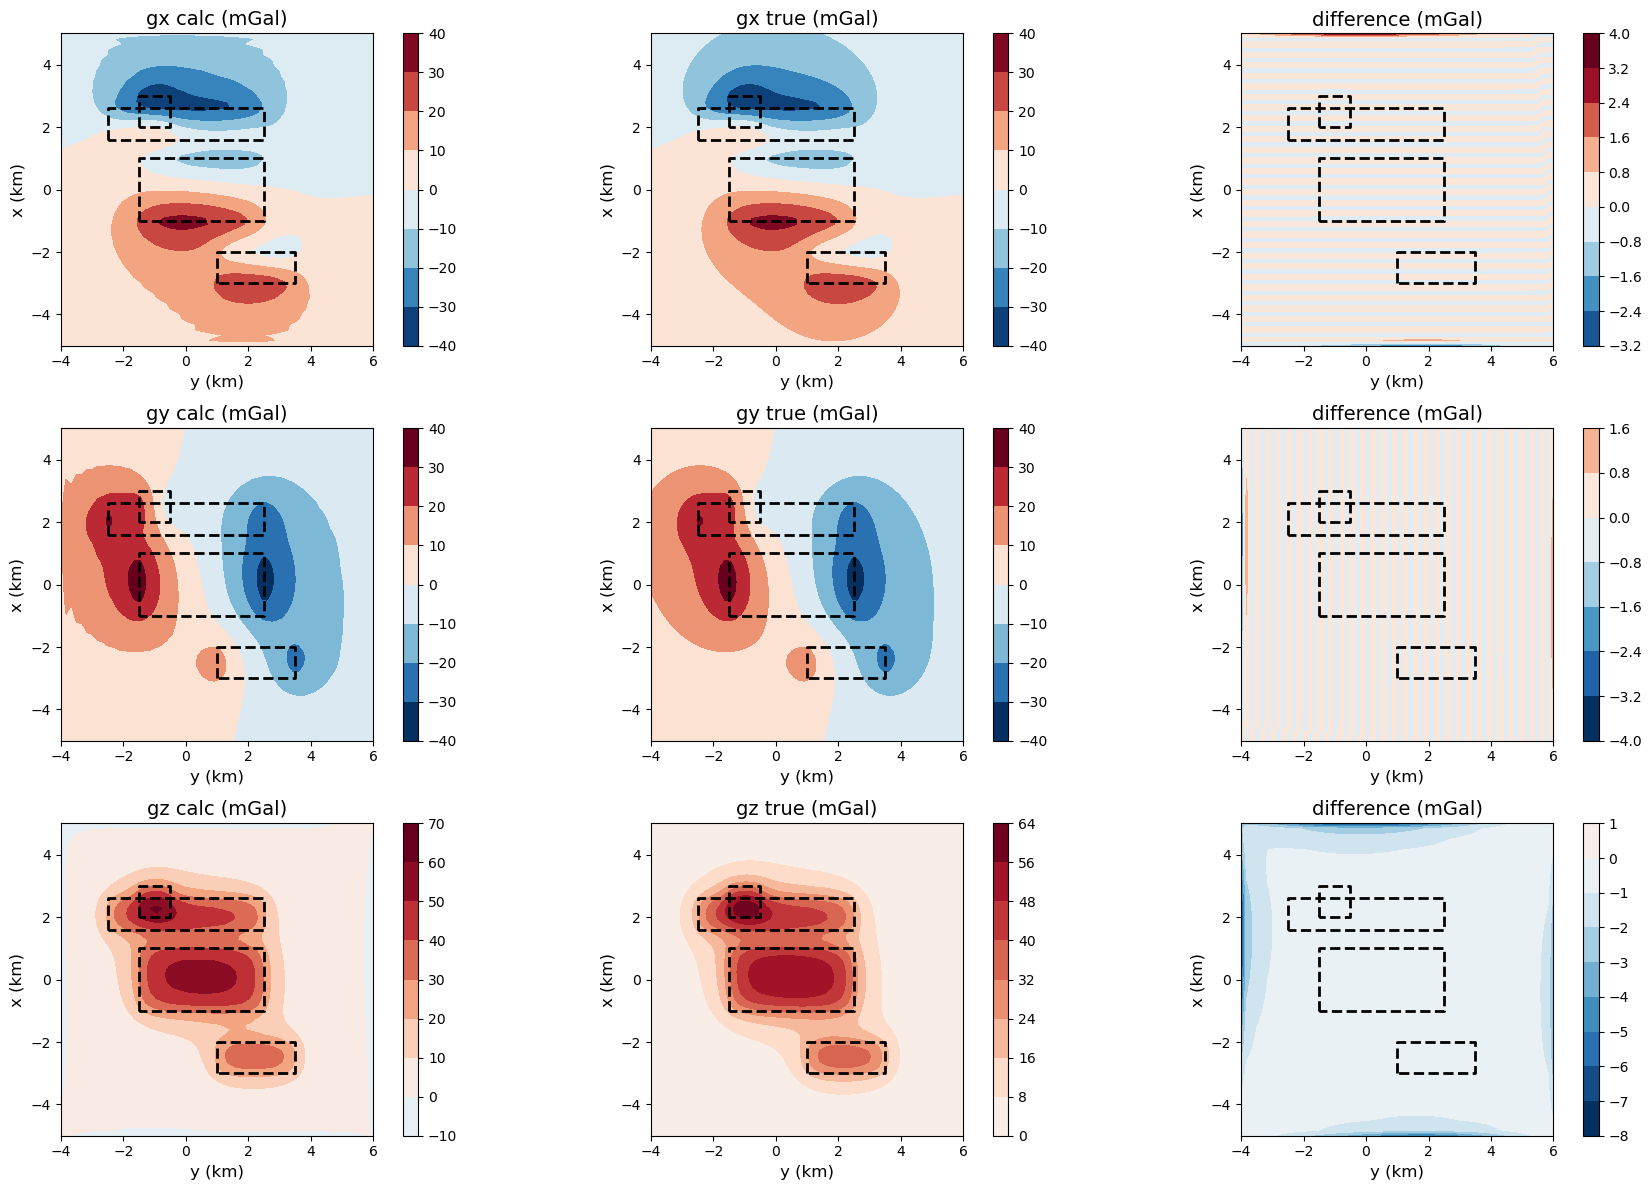

In [18]:
true_fields = [gx, gy, gz]

bounds, diffs = plf.bounds_diffs(g_estimated, true_fields)

fields = plf.fields_list(g_estimated, true_fields, diffs)

titles = [
    'gx calc (mGal)', 'gx true (mGal)', 'difference (mGal)',
    'gy calc (mGal)', 'gy true (mGal)', 'difference (mGal)',
    'gz calc (mGal)', 'gz true (mGal)', 'difference (mGal)'
]

windows = [1, 2, 3, 4, 5, 6, 7, 8, 9]

plt.figure(figsize=(18,12))

for w, window in enumerate(windows):
    plt.subplot(3,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        Y*0.001, X*0.001, 
        data_structures.grid_xy_full_flatten_to_matrix(
            data=fields[w], ordering='xy', shape=coordinates_grid['shape']
        ), 
        cmap='RdBu_r',
        vmin = -bounds[w], vmax = bounds[w]
    )
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
    plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

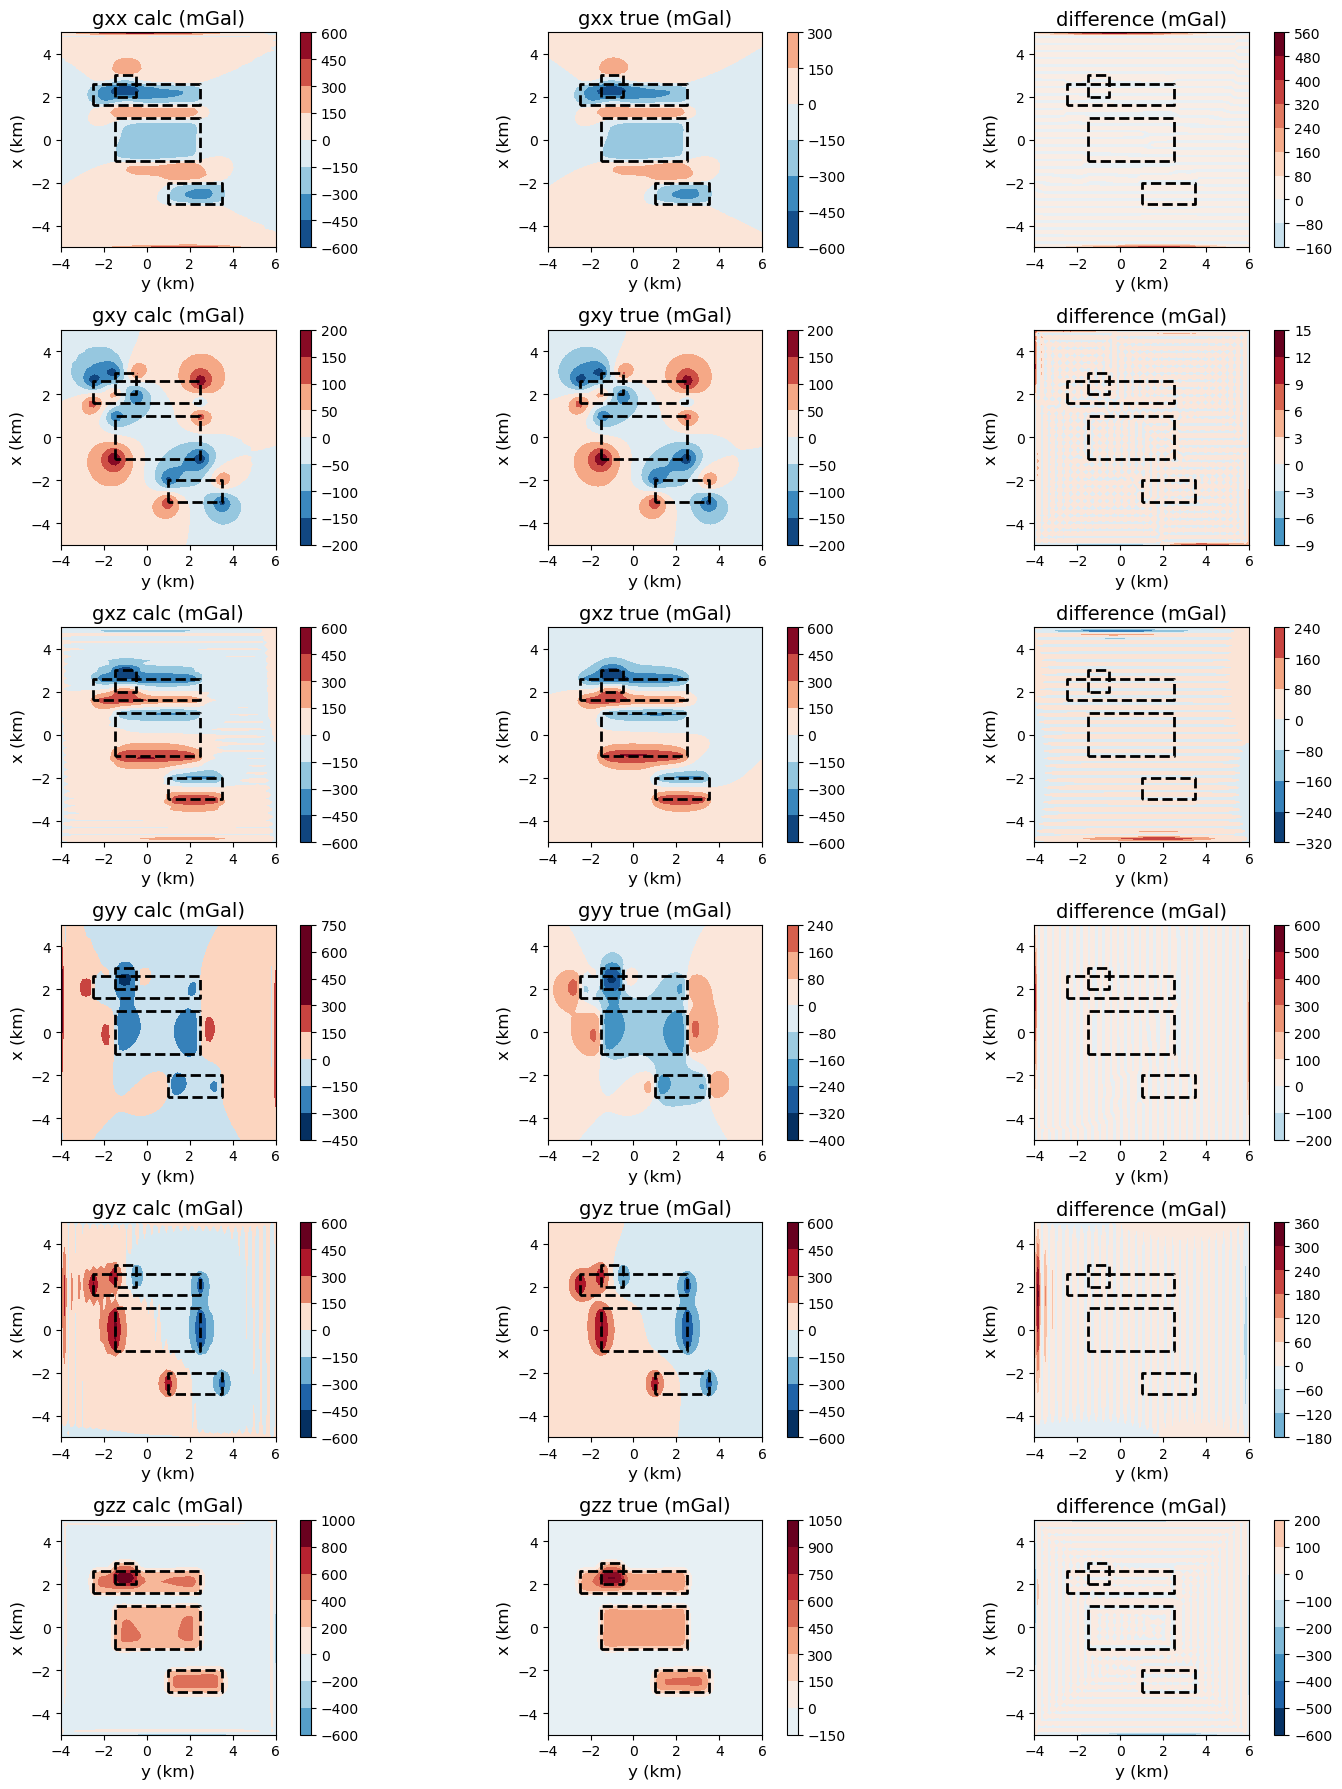

In [19]:
true_fields = [gxx, gxy, gxz, gyy, gyz, gzz]

bounds, diffs = plf.bounds_diffs(g_tensor_estimated, true_fields)

fields = plf.fields_list(g_tensor_estimated, true_fields, diffs)

titles = [
    'gxx calc (mGal)', 'gxx true (mGal)', 'difference (mGal)',
    'gxy calc (mGal)', 'gxy true (mGal)', 'difference (mGal)',
    'gxz calc (mGal)', 'gxz true (mGal)', 'difference (mGal)',
    'gyy calc (mGal)', 'gyy true (mGal)', 'difference (mGal)',
    'gyz calc (mGal)', 'gyz true (mGal)', 'difference (mGal)',
    'gzz calc (mGal)', 'gzz true (mGal)', 'difference (mGal)'
]

windows = [i for i in range(1, 19)]

plt.figure(figsize=(15,18))

for w, window in enumerate(windows):
    plt.subplot(6,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        Y*0.001, X*0.001, 
        data_structures.grid_xy_full_flatten_to_matrix(
            data=fields[w], ordering='xy', shape=coordinates_grid['shape']
        ), 
        cmap='RdBu_r',
        vmin = -bounds[w], vmax = bounds[w]
    )
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
    plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

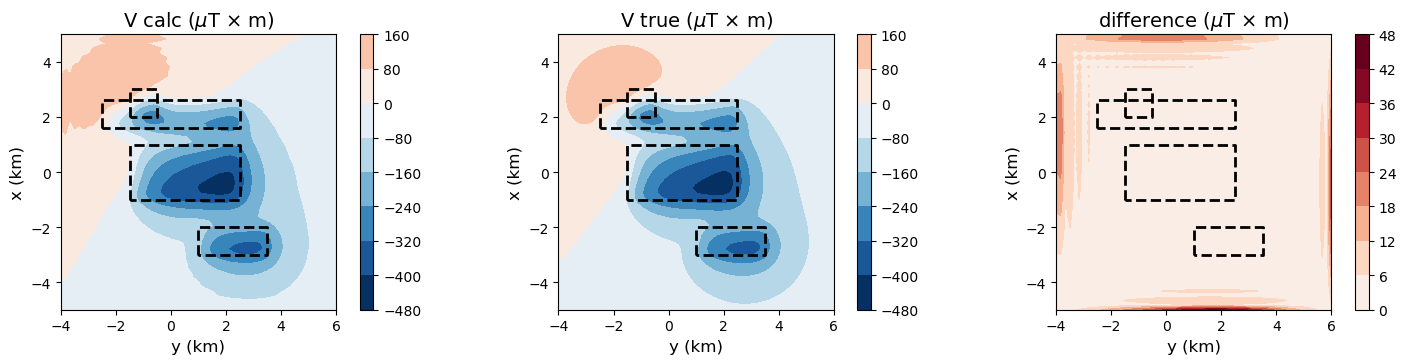

In [20]:
true_fields = [V]

bounds, diffs = plf.bounds_diffs(mag_potential_estimated, true_fields)

fields = plf.fields_list(mag_potential_estimated, true_fields, diffs)

titles = [
    'V calc ($\mu$T $\\times$ m)', 
    'V true ($\mu$T $\\times$ m)', 
    'difference ($\mu$T $\\times$ m)'
]

windows = [1, 2, 3]

plt.figure(figsize=(15,10))

for w, window in enumerate(windows):
    plt.subplot(3,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        Y*0.001, X*0.001, 
        data_structures.grid_xy_full_flatten_to_matrix(
            data=fields[w], ordering='xy', shape=coordinates_grid['shape']
        ), 
        cmap='RdBu_r',
        vmin = -bounds[w], vmax = bounds[w]
    )
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
    plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

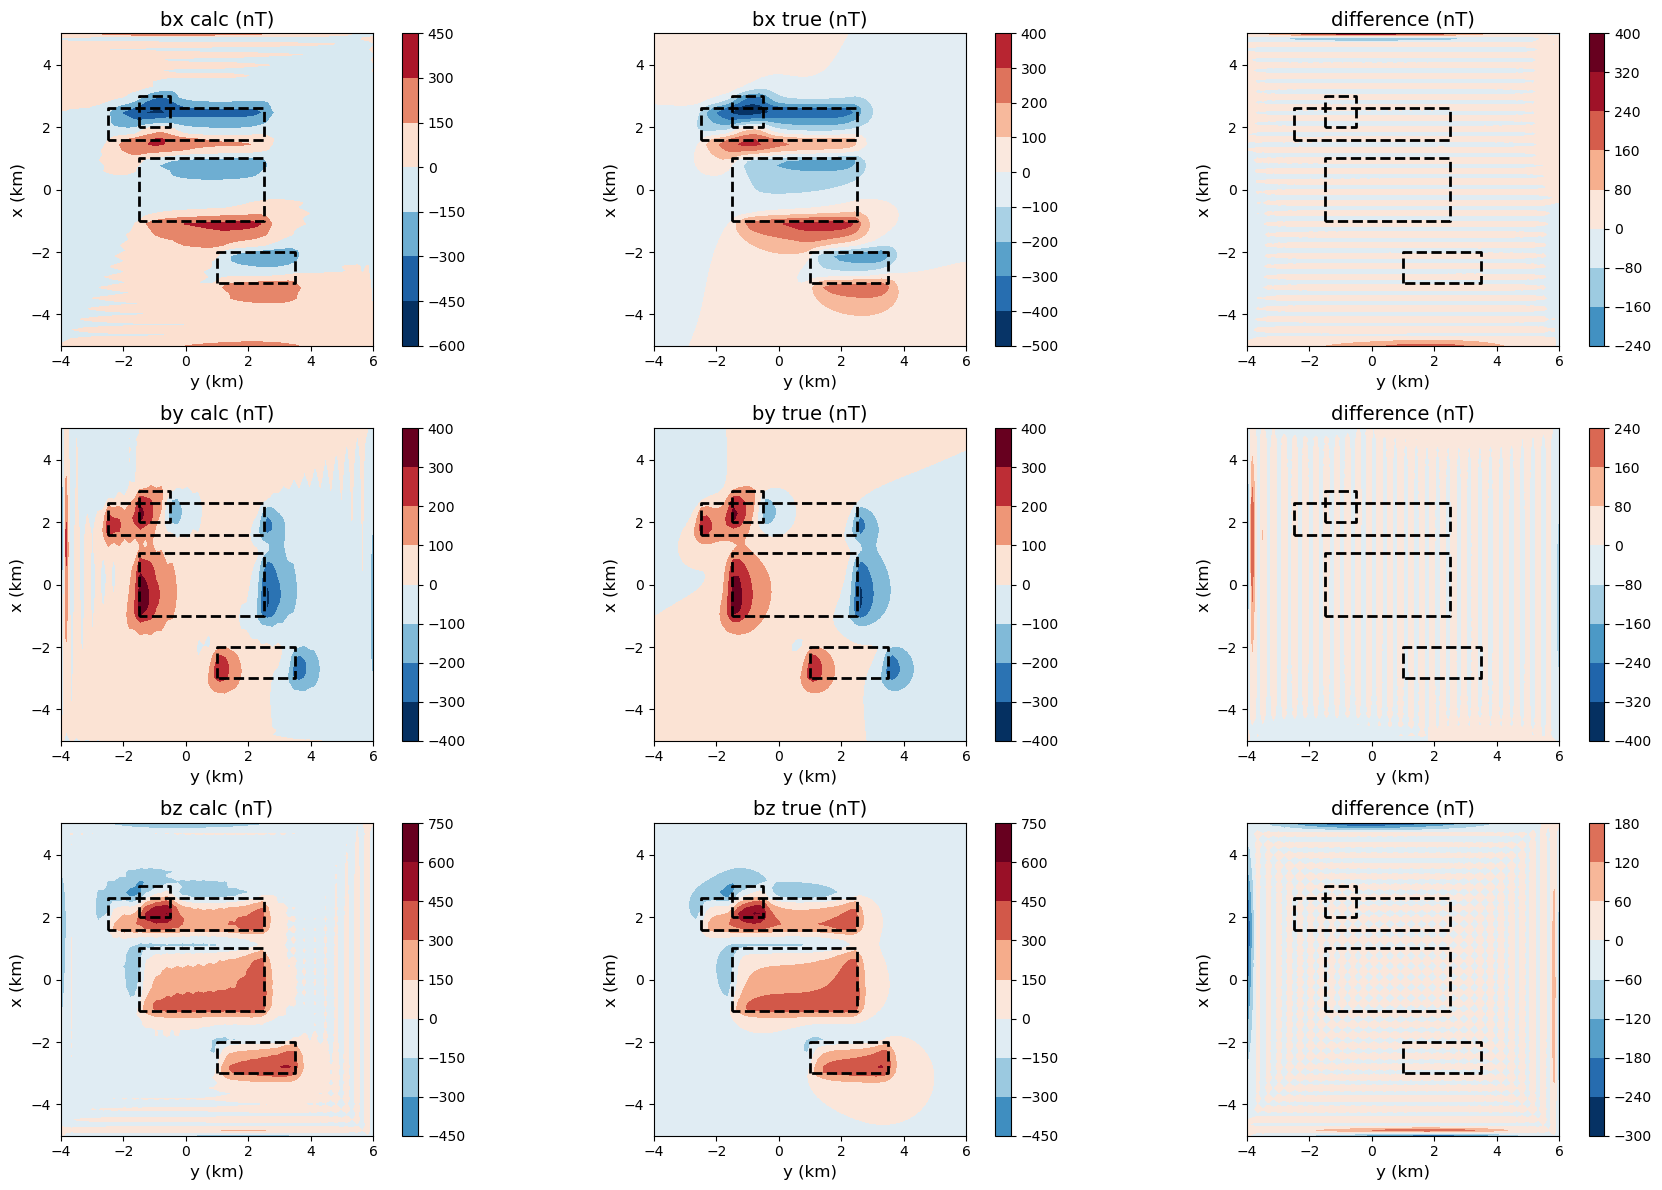

In [21]:
true_fields = [bx, by, bz]

bounds, diffs = plf.bounds_diffs(b_estimated, true_fields)

fields = plf.fields_list(b_estimated, true_fields, diffs)

titles = [
    'bx calc (nT)', 'bx true (nT)', 'difference (nT)',
    'by calc (nT)', 'by true (nT)', 'difference (nT)',
    'bz calc (nT)', 'bz true (nT)', 'difference (nT)'
]

windows = [1, 2, 3, 4, 5, 6, 7, 8, 9]

plt.figure(figsize=(18,12))

for w, window in enumerate(windows):
    plt.subplot(3,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        Y*0.001, X*0.001, 
        data_structures.grid_xy_full_flatten_to_matrix(
            data=fields[w], ordering='xy', shape=coordinates_grid['shape']
        ), 
        cmap='RdBu_r',
        vmin = -bounds[w], vmax = bounds[w]
    )
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
    plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()